# `torchopt.stop_gradient` in Meta-Learning

In this tutoial, we will illustrate the usage of torchopt.stop_gradient with a meta-learning example. We use torchopt.visual to help us visualize what is going on in automatic differentiation. Firstly, we define a simple network and the objective function for inner, outer optimization.

In [53]:
import torch
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, 1)
    
    def forward(self, x):
        return self.fc(x)

def fn(x):
    return 2 * x + 1

loss_fn = F.mse_loss

We define the input x and output y. y will be served as the regression target in the following code.

In [54]:
x = torch.rand(5, 1)
y = fn(x)
net = Net()

Let us define the meta-parameter, MetaSGD as the inner-loop optimizer, Adam as the outer-loop optimizer. 

In [55]:
import torchopt
from torchopt import MetaSGD
from matplotlib import image as imgplt
from matplotlib import pyplot as plt

meta_parameter = torch.tensor([1.], requires_grad=True)
optim = MetaSGD(net, lr=1e-1)
meta_optim = torch.optim.Adam([meta_parameter], lr=1e-1)

Define the inner-loop optimization and visualize the inner-loop forward gradient flow.

inner loss: 4.4117


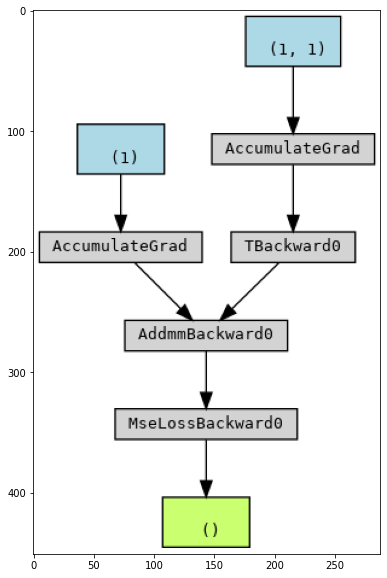

In [56]:
# inner loss
loss = loss_fn(net(x), y)
print(f"inner loss: {loss:.4f}")
torchopt.visual.make_dot(loss).render("full_graph", format="png")
plt.figure(figsize=(10,10))
plt.imshow(imgplt.imread('full_graph.png'))

Conduct inner-loop optimization with MetaSGD, here the meta-parameter is served as a factor controling the scale of inner-loop loss.

In [57]:
# inner-step optimization
loss = loss * meta_parameter
optim.step(loss)

We compute the outer loss and draw the full computation graph of the first bi-level process. In this graph, three main parts are included.
- Inner-loop: forward process and inner-loss calculation
- Inner-loop optimization: MetaSGD optimization step given inner-loss
- Outer-loop: forward process and outer-loss calculation

outer loss: 1.5181


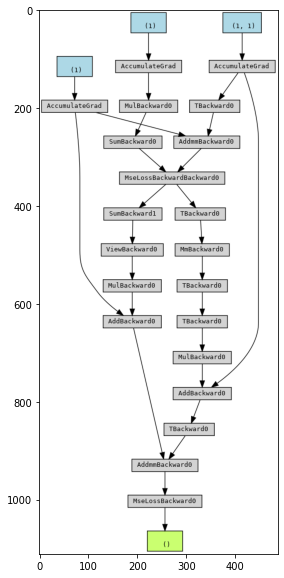

In [61]:
# extract state_dict for updated network
one_step_net_state = torchopt.extract_state_dict(net)
one_step_optim_state = torchopt.extract_state_dict(optim)
# calculate outer loss
outer_loss = loss_fn(net(x), y)
print(f"outer loss: {outer_loss:.4f}")
torchopt.visual.make_dot(outer_loss).render("full_graph", format="png")
plt.figure(figsize=(10,10))
plt.imshow(imgplt.imread('full_graph.png'))

Then we backward the loss to conduct outer-loop meta optimization.

In [41]:
meta_optim.zero_grad()
outer_loss.backward()
print(meta_parameter.grad)
meta_optim.step()
print(meta_parameter)

tensor([-0.0537])
tensor([1.1000], requires_grad=True)


We have already conducted one bi-level optimization and optimize our meta-parameters. When you want to conduct the second bi-level optimization, you need to be careful whether you need to use the `stop_gradient` function. For example, if your new inner-loop parameters directly inherits previous inner-loop parameters (which is a common strategy in many meta-learning algorithms like MGRL), you might need `stop_gradient` function.

In general, the back-propagation only free saved tensors (often used as auxiliary data for computing the gradient) but the computation graph remains. Once the outer iteration is finished, if you want to use any intermediate network parameters produced by the inner loop for the next bi-level iteration, you should detach them from the computation graph.
There are two main reasons:
- The network parameters are still connected to the previous computation graph (`.grad_fn` is not `None`). If later the gradient back-propagate to these parameters, the PyTorch backward engine will try to back-propagate through the previous computation graph. Which will raise a `RuntimeError`: Trying to backward through the graph a second time...
- If we do not detach the computation graph, the computation graph connected to these parameters can not be freed by GC (Garbage Collector) until these parameters are collected by GC.

Now let us see what will happen if we do not use the `stop_gradient` function before we conduct the second bi-level process.

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

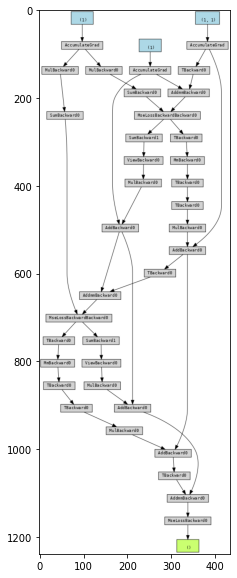

In [48]:
inner_loss = loss_fn(net(x), y)
loss = inner_loss * meta_parameter
optim.step(loss)
outer_loss = loss_fn(net(x), y)
torchopt.visual.make_dot(outer_loss).render("full_graph", format="png")
plt.figure(figsize=(10,10))
plt.imshow(imgplt.imread('full_graph.png'))
meta_optim.zero_grad()
outer_loss.backward()
meta_optim.step()

From the graph we can see, directly conducting the second bi-level process links the graph of first and second bi-level process together. We should manually stop gradient with `torchopt.stop_gradient`. `torchopt.stop_gradient` will detach the node of gradient graph and make it become a leaf node. It allows the input of network, optimizer, or state dictionary and the gradient operation happens in an inplace manner.

Let's use recover_state_dict to come back to one-step updated states.

In [59]:
# Reset to previous one-step updated states
torchopt.recover_state_dict(net, one_step_net_state)
torchopt.recover_state_dict(optim, one_step_optim_state)

And finally, Let's conduct the stop-gradient operation before the second meta-optimization step. 

tensor([1.1950], requires_grad=True)


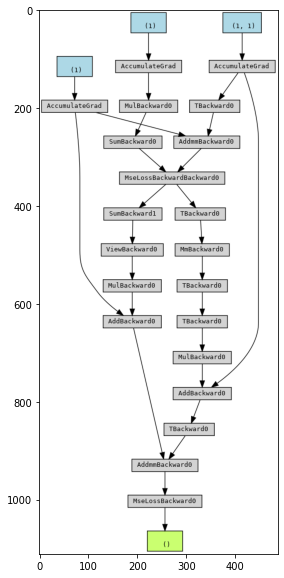

In [62]:
# stop gradient and make them become the leaf node
torchopt.stop_gradient(net)
torchopt.stop_gradient(optim)

inner_loss = loss_fn(net(x), y)
loss = inner_loss * meta_parameter
optim.step(loss)
outer_loss = loss_fn(net(x), y)
torchopt.visual.make_dot(outer_loss).render("full_graph", format="png")
plt.figure(figsize=(10,10))
plt.imshow(imgplt.imread('full_graph.png'))
meta_optim.zero_grad()
outer_loss.backward()
meta_optim.step()
print(meta_parameter)

The gradient graph is the same with the first meta-optimization's gradient graph and we successfully conduct the second bi-level process.